# <center>ASL Recognition Model</center>

### Initialization

In [1]:
import zipfile

# give permissions to kaggle API
! pip install kaggle
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle
! chmod 600 /root/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# download dataset from kaggle to colab
! kaggle datasets download -d grassknoted/asl-alphabet

# extract the content of the zipped file
zip_ref = zipfile.ZipFile('asl-alphabet.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


### Modules & Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50V2, DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization

import os
import cv2
import glob
import pickle
import random
import warnings


# drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')
%matplotlib inline

### Exploratory Data Analysis

In [4]:
batch_size = 32
img_height = 128
img_width = 128
epochs = 30
num_classes = 27
img_channels = 3

In [5]:
# Define the path to the main folder
import os
import shutil

# Define the main folder path
main_folder_path = r'C:\Users\niraj\Downloads\archive\ASL_Alphabet_Dataset\asl_alphabet_train'

# Remove specific folders if they exist
folders_to_remove = ['del', 'nothing']

for folder in folders_to_remove:
    folder_path = os.path.join(main_folder_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Deletes the folder and its contents
        print(f"Deleted: {folder_path}")

# Get a list of subfolders within the main folder
subfolders = os.listdir(main_folder_path)

print("Remaining subfolders:", subfolders)


Deleted: C:\Users\niraj\Downloads\archive\ASL_Alphabet_Dataset\asl_alphabet_train\del
Deleted: C:\Users\niraj\Downloads\archive\ASL_Alphabet_Dataset\asl_alphabet_train\nothing
Remaining subfolders: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


#### Visualization of image from each class

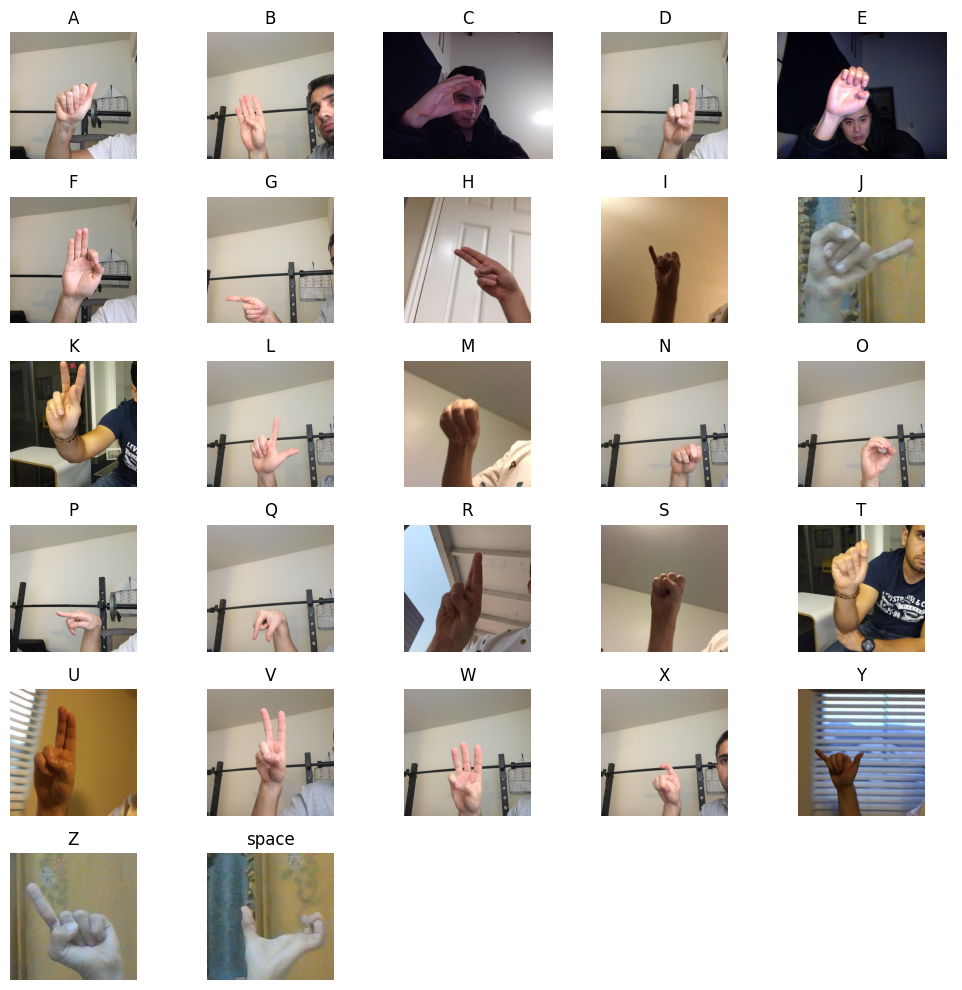

In [6]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

#### Visualization of number of images in each class

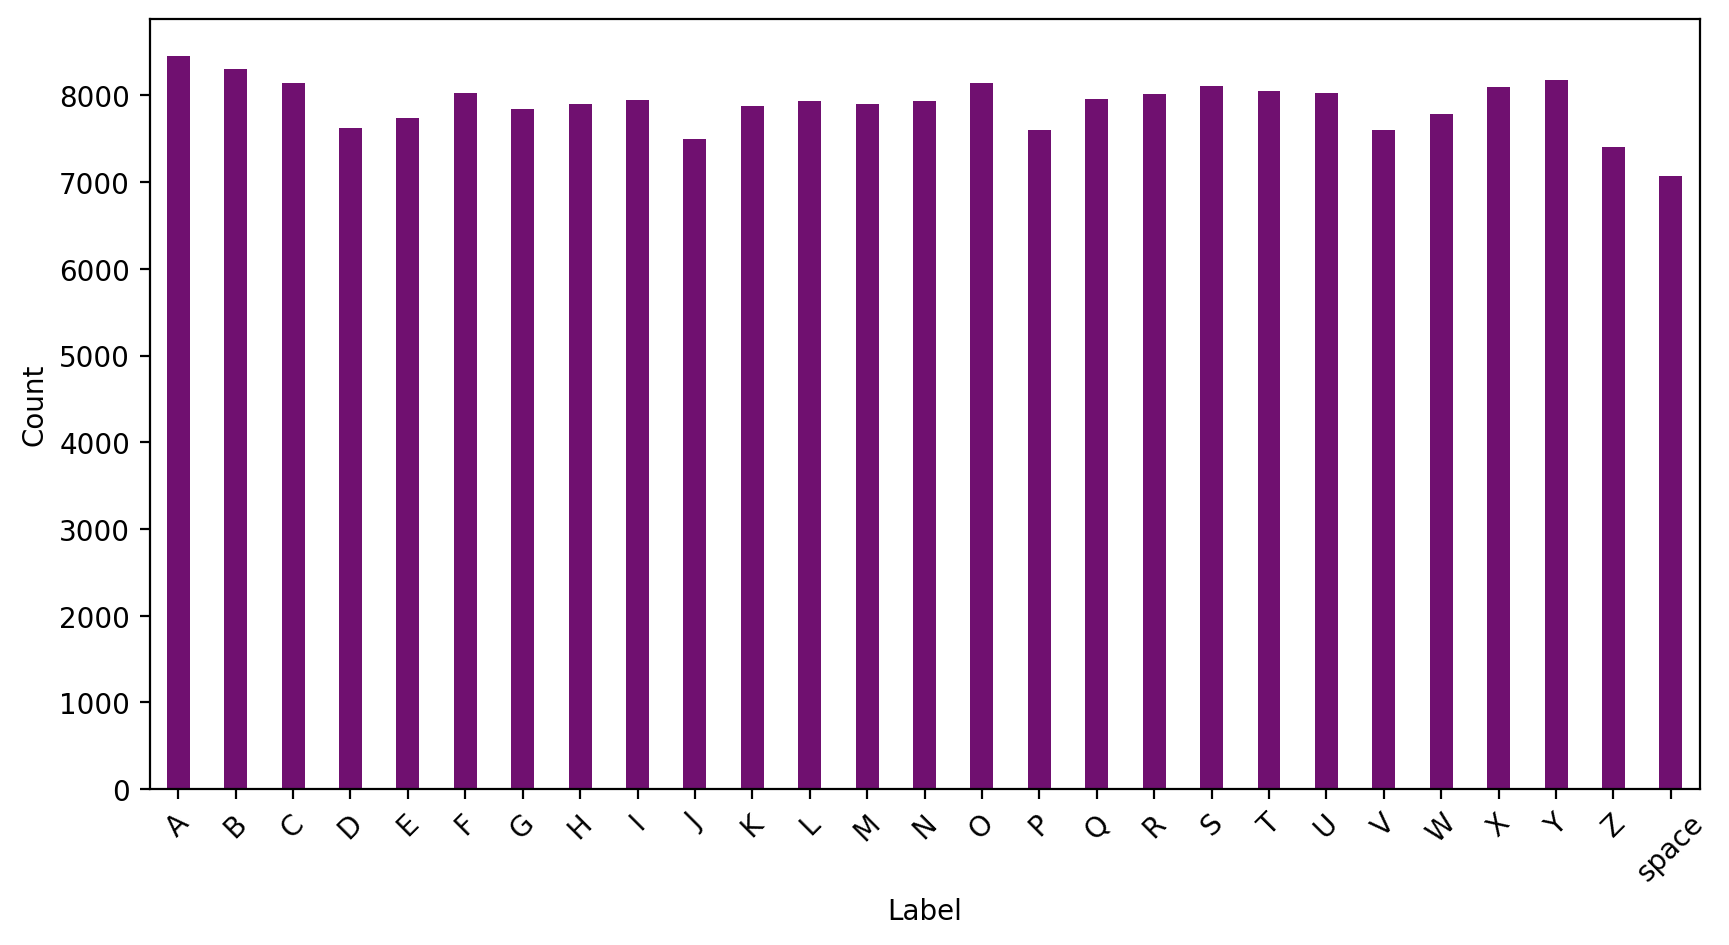

In [7]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.title('Class distribution in Dataset',fontsize=15)

sns.barplot(data=df, x='Label', y='Count', width=0.4, color='purple')

plt.xticks(rotation = 45)
plt.show()

In [8]:
df['Count'].min(), df['Count'].max()

(7071, 8458)

Since there are 3000 images in each clas, we can conclude that the dataset is balanced.

In [9]:
categories

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'space'}

#### Distribution of dimension of the images

In [10]:
width_dim = []
height_dim = []

def get_dimension():
    sub_dataset_path = f'/content/asl_alphabet_train/asl_alphabet_train'
    letters = os.listdir(sub_dataset_path)

    for letter in letters:
        letter_path = os.path.join(sub_dataset_path, letter)

        for image in os.listdir(letter_path):

            image_path = os.path.join(letter_path, image)
            img = mimg.imread(image_path)
            d1, d2, colors = img.shape

            width_dim.append(d1)
            height_dim.append(d2)

get_dimension()

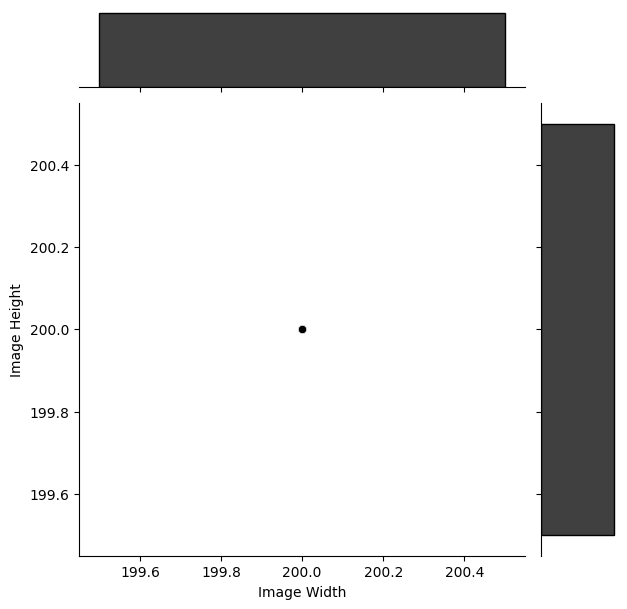

In [11]:
sns.jointplot(x=width_dim, y=height_dim, color='black')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

In [12]:
stats.mode(width_dim), stats.mode(height_dim), 3

(ModeResult(mode=200, count=87000), ModeResult(mode=200, count=87000), 3)

The dimension of each image in the dataset is 200x200.

In [13]:
image_shape = (128, 128, 3)
print(200*200*3)
print(128*128*3)

120000
49152


### Data Preprocessing

In [14]:
# Create dataframe
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

# dataframe

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.20,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [16]:
datagen = image.ImageDataGenerator(rescale=1./255.,)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="sparse",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)






# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="sparse",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="sparse",
    batch_size=1,
    target_size=(img_height, img_width),
    shuffle=False
)

Found 144980 validated image filenames belonging to 27 classes.
Found 36246 validated image filenames belonging to 27 classes.
Found 31982 validated image filenames belonging to 27 classes.


### Model Training

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

**VGG16**

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,186,011 (73.19 MB)

 Trainable params: 19,186,011 (73.19 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
# display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │        13,85

 Total params: 19,186,011 (73.19 MB)

 Trainable params: 4,471,323 (17.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

In [20]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Train the Model
model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3667 - loss: 1.9860

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6576s 1s/step - accuracy: 0.3667 - loss: 1.9859 - val_accuracy: 0.8756 - val_loss: 0.5000 - learning_rate: 0.0010
Epoch 2/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 644s 142ms/step - accuracy: 0.7188 - loss: 1.0537 - val_accuracy: 0.8679 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 3/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6294 - loss: 1.0755

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3655s 807ms/step - accuracy: 0.6294 - loss: 1.0755 - val_accuracy: 0.8927 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 4/30
   1/4530 ━━━━━━━━━━━━━━━━━━━━ 48:01 636ms/step - accuracy: 0.5625 - loss: 1.1608

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 641s 141ms/step - accuracy: 0.5625 - loss: 1.1608 - val_accuracy: 0.8947 - val_loss: 0.4167 - learning_rate: 0.0010
Epoch 5/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6899 - loss: 0.9184

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3516s 776ms/step - accuracy: 0.6899 - loss: 0.9184 - val_accuracy: 0.8955 - val_loss: 0.3867 - learning_rate: 0.0010
Epoch 6/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 643s 142ms/step - accuracy: 0.7812 - loss: 0.6919 - val_accuracy: 0.8910 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 7/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7121 - loss: 0.8589
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3480s 768ms/step - accuracy: 0.7121 - loss: 0.8589 - val_accuracy: 0.8607 - val_loss: 0.4739 - learning_rate: 0.0010
Epoch 8/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 641s 141ms/step - accuracy: 0.7188 - loss: 0.7267 - val_accuracy: 0.8618 - val_loss: 0.4723 - learning_rate: 5.0000e-04
Epoch 9/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7749 - loss: 0.6734

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 3425s 756ms/step - accuracy: 0.7749 - loss: 0.6734 - val_accuracy: 0.9073 - val_loss: 0.3063 - learning_rate: 5.0000e-04
Epoch 10/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 647s 143ms/step - accuracy: 0.7188 - loss: 0.7839 - val_accuracy: 0.9066 - val_loss: 0.3090 - learning_rate: 5.0000e-04
Epoch 11/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7927 - loss: 0.6225

4530/4530 ━━━━━━━━━━━━━━━━━━━━ 13689s 3s/step - accuracy: 0.7927 - loss: 0.6225 - val_accuracy: 0.9316 - val_loss: 0.2435 - learning_rate: 5.0000e-04
Epoch 12/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 663s 146ms/step - accuracy: 0.7188 - loss: 0.8181 - val_accuracy: 0.9307 - val_loss: 0.2473 - learning_rate: 5.0000e-04
Epoch 13/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.8039 - loss: 0.5911

KeyboardInterrupt: 

## Model Evaluation

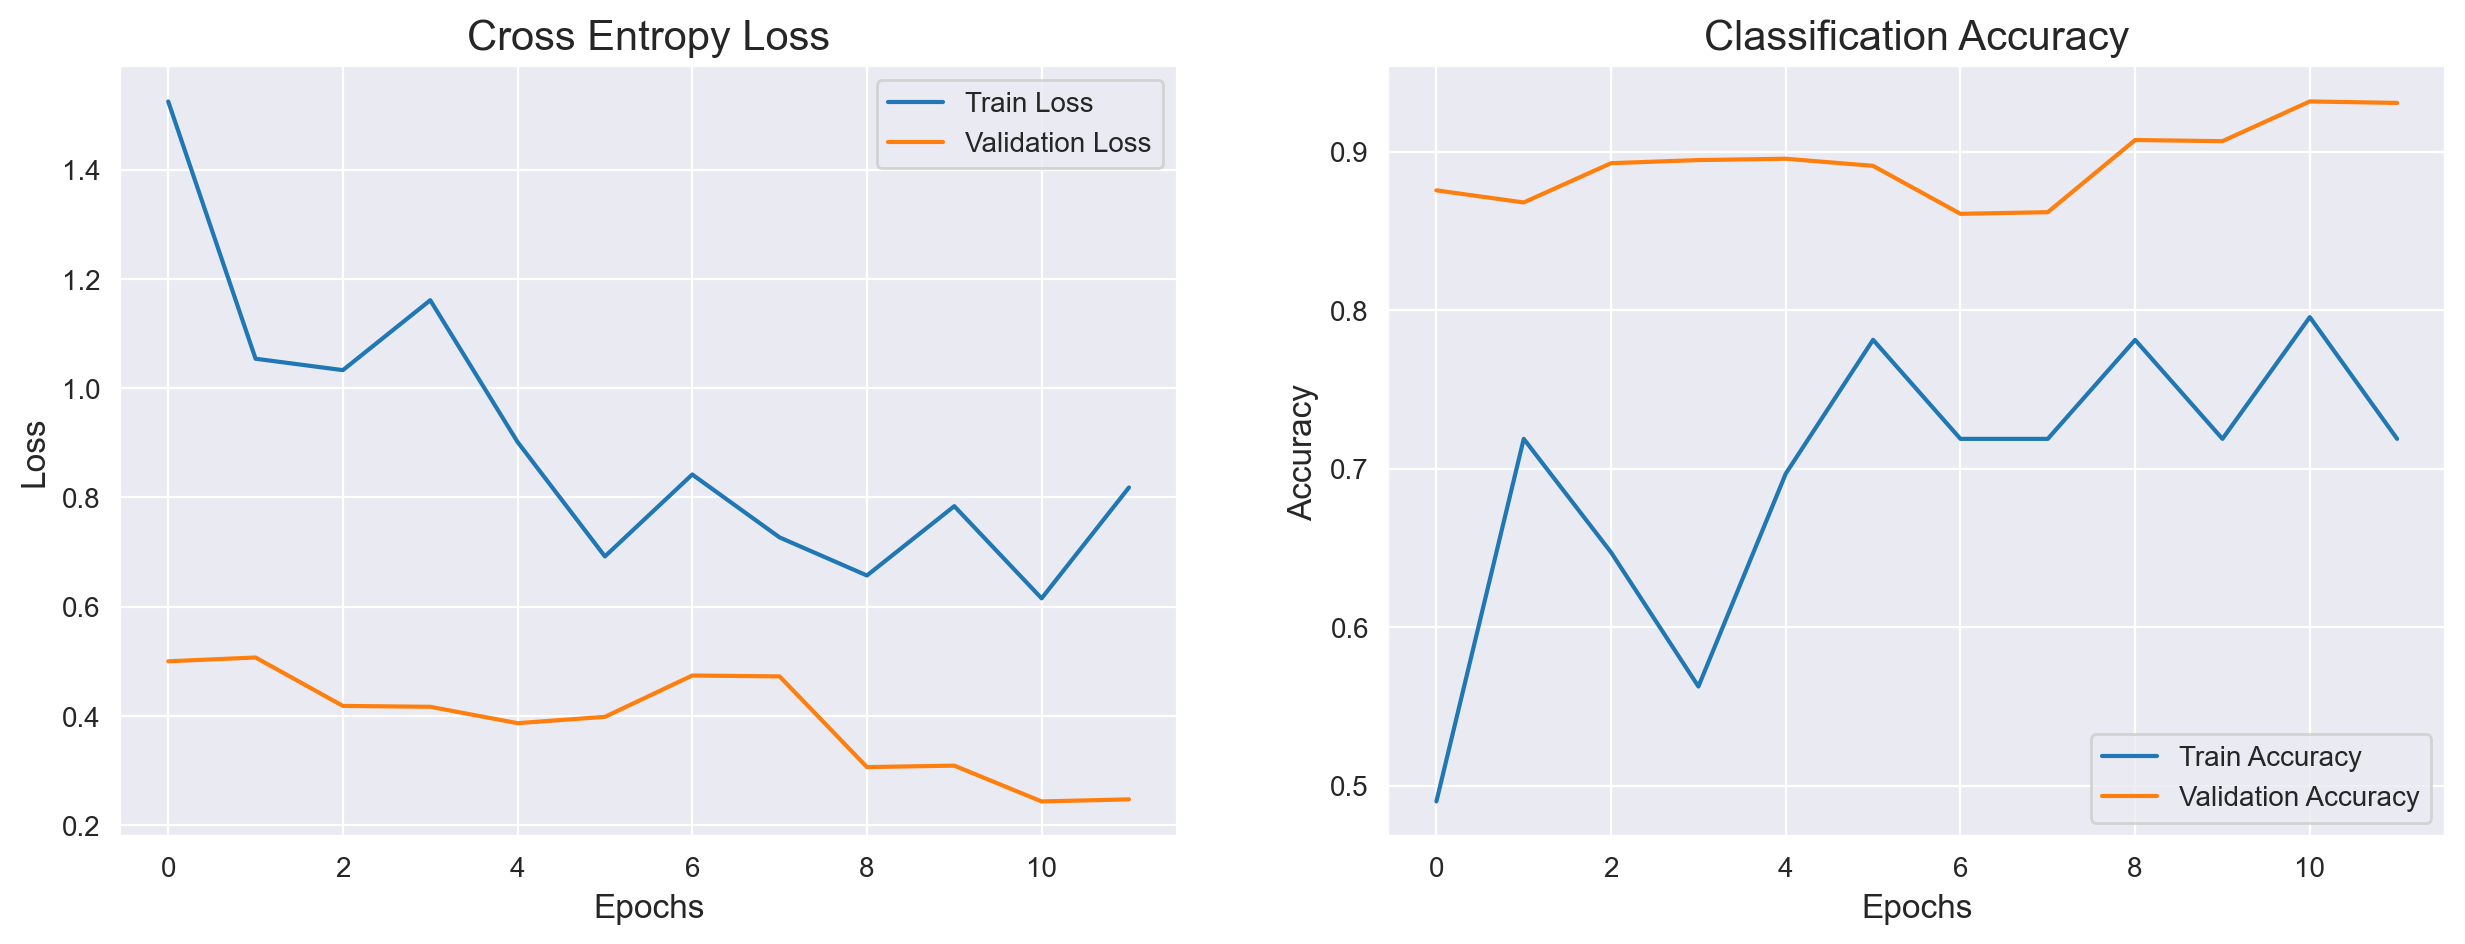

In [23]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [24]:
# Evaluate test dataset
loss, acc = model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 88.28403353691101
The Loss of the model for testing data is: 0.35176193714141846


In [25]:
predicted_class = model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 28235
Incorrect predicted classes: 3747


In [26]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       0.91      0.81      0.86      1269
           B       1.00      0.90      0.95      1246
           C       0.98      0.96      0.97      1222
           D       0.98      0.95      0.97      1144
           E       0.97      0.84      0.90      1162
           F       1.00      0.96      0.98      1205
           G       0.57      0.94      0.71      1177
           H       0.98      0.30      0.46      1186
           I       0.83      0.97      0.89      1193
           J       0.93      0.96      0.94      1125
           K       1.00      0.80      0.89      1181
           L       0.99      0.96      0.97      1191
           M       0.98      0.84      0.90      1185
           N       0.84      0.92      0.88      1190
           O       0.96      0.97      0.97      1221
           P       0.99      0.93      0.96      1140
           Q       1.00      0.97      0.98      1193
           R       0.96    

In [27]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

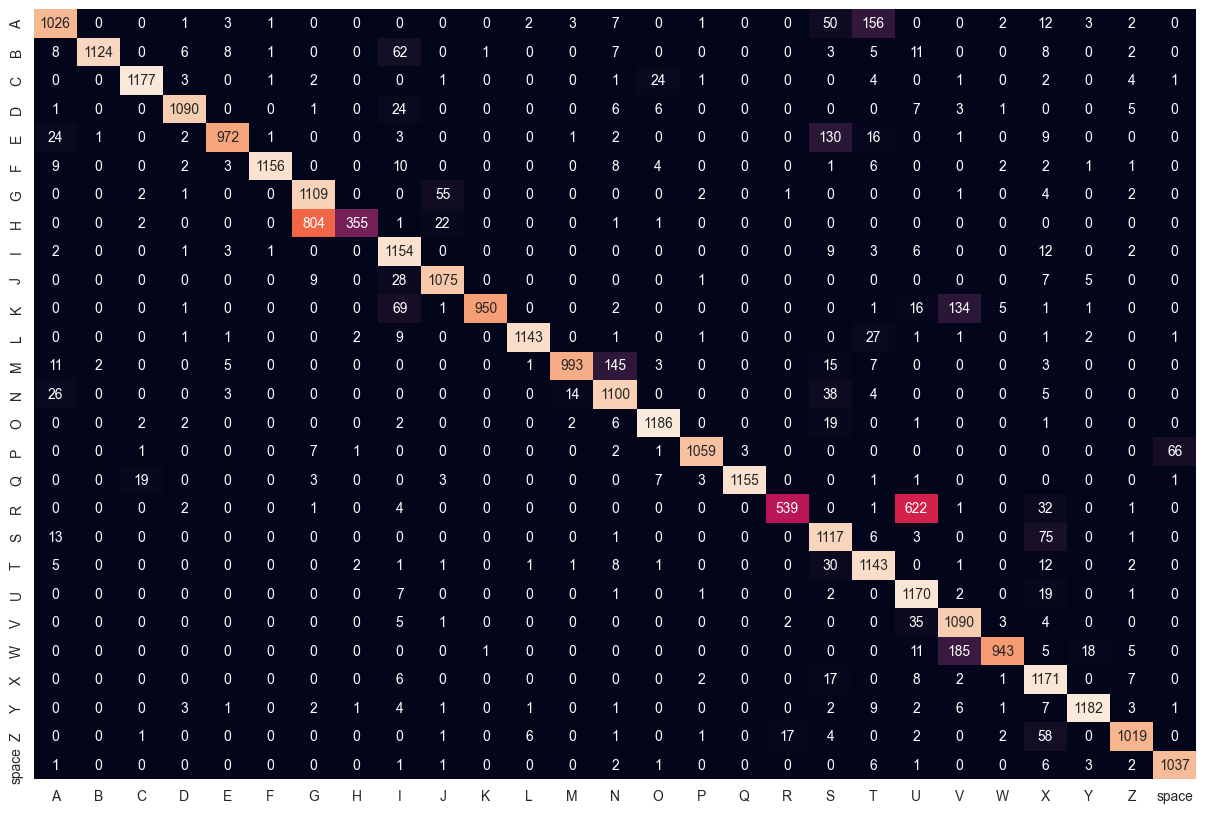

In [28]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

In [29]:
test_images = '/content/asl_alphabet_test/asl_alphabet_test'

for i in os.listdir(test_images):
  img = os.path.join(test_images, i)
  print(f'Image: {i}', end='\t\t')
  img = cv2.imread(img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (128, 128))

  img = image.img_to_array(img)

  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  predict = model.predict(img, verbose=False)
  predict_class = np.argmax(predict, axis=1)

  print("Prediction: ", categories[tuple(predict_class)[0]], end='\n\n')

Image: A_test.jpg		Prediction:  A

Image: B_test.jpg		Prediction:  B

Image: C_test.jpg		Prediction:  C

Image: D_test.jpg		Prediction:  D

Image: E_test.jpg		Prediction:  E

Image: F_test.jpg		Prediction:  F

Image: G_test.jpg		Prediction:  G

Image: H_test.jpg		Prediction:  J

Image: I_test.jpg		Prediction:  I

Image: J_test.jpg		Prediction:  I

Image: K_test.jpg		Prediction:  V

Image: L_test.jpg		Prediction:  L

Image: M_test.jpg		Prediction:  N

Image: nothing_test.jpg		Prediction:  B

Image: N_test.jpg		Prediction:  N

Image: O_test.jpg		Prediction:  O

Image: P_test.jpg		Prediction:  P

Image: Q_test.jpg		Prediction:  Q

Image: R_test.jpg		Prediction:  R

Image: space_test.jpg		Prediction:  space

Image: S_test.jpg		Prediction:  S

Image: T_test.jpg		Prediction:  T

Image: U_test.jpg		Prediction:  U

Image: V_test.jpg		Prediction:  V

Image: W_test.jpg		Prediction:  W

Image: X_test.jpg		Prediction:  X

Image: Y_test.jpg		Prediction:  Y

Image: Z_test.jpg		Prediction:  X



## Save Model

In [30]:
model.save('vgg16_model7.h5')
! cp vgg16_model7.h5 /content/gdrive/MyDrive/Models/
! cp /content/asl_vgg16_best_weights.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


## Feature Extraction

In [31]:
fine_tuned_model = load_model("best_weights.h5")

In [32]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,160 (73.14 MB)

 Trainable params: 4,457,472 (17.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

# Assuming the dense_model is pre-loaded somewhere
# Example: dense_model = load_model('path_to_dense_model.h5')

# Function to extract features using the dense model
def dense_feature_prediction(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]  # Assuming dense_model is loaded
    return dense_feature

# Ensure 'labels' is defined before this loop
labels = test_df["label"].unique()

# Create an empty dataframe to store features
reduction_data = pd.DataFrame()

# Collect data for each label
for label in labels:
    label_data = test_df[test_df["label"] == label][:100]
    reduction_data = pd.concat([reduction_data, label_data], ignore_index=True)

# Reset index for final dataframe
reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

# Extract features for each image path
dense_features = reduction_data["image_path"].apply(dense_feature_prediction)

# Convert the extracted features into a dataframe
dense_features_df = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)


,image_path,label
0,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
1,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
2,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
3,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
4,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A
...,...,...
2695,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E
2696,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E
2697,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E
2698,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E


In [34]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# Ensure dense_features is a 2D numpy array (num_samples, num_features)
dense_features_array = np.vstack(dense_features.values)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=0.99, init='pca')

# Perform t-SNE
tsne_features = tsne.fit_transform(dense_features_array)

# Convert the t-SNE features into a DataFrame
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])

# Add the t-SNE features to the original dataframe
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features

# Display the result
display(reduction_data)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.002s...
[t-SNE] Computed neighbors for 2700 samples in 0.396s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 2.611498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.256889
[t-SNE] KL divergence after 1000 iterations: 0.588106


,image_path,label,tsne_feat_0,tsne_feat_1
0,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,-0.286719,16.573261
1,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,1.799956,15.332030
2,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,-0.058614,9.093818
3,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,3.045488,2.279758
4,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,A,-3.490862,13.747561
...,...,...,...,...
2695,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,-1.635758,12.265478
2696,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,-7.720423,13.850319
2697,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,-9.574345,16.677834
2698,C:\Users\niraj\Downloads\archive\ASL_Alphabet_...,E,-8.585140,19.080088


In [36]:
reduction_data.to_csv('dataframe.csv')

In [37]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [38]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000",
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

In [39]:
fig.write_html('feat_ext.html')

**CNN**

In [41]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (5, 5), input_shape=image_shape)) ##32 filters, 5x5 kernel, input shape is 128x128x3
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Flatten()) ##flatten the data
cnn_model.add(Dense(128, activation='relu')) ##128 neurons, activation function
cnn_model.add(Dense(27, activation='softmax')) ##output layer, 27 neurons, activation function

display(cnn_model.summary())
display(tf.keras.utils.plot_model(cnn_model, to_file='cnn.png', show_shapes=True))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,099 (6.36 MB)

 Trainable params: 1,667,099 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

None

You must install pydot (`pip install pydot`) for `plot_model` to work.


None

In [79]:

# Compile and train the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the Model
cnn_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/30


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 7), output.shape=(None, 27)

In [80]:
cnn_model.save('cnn_model.h5')
! cp cnn_model.h5 /content/gdrive/MyDrive/Models/
! cp feat_ext.html /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


KeyError: 'loss'

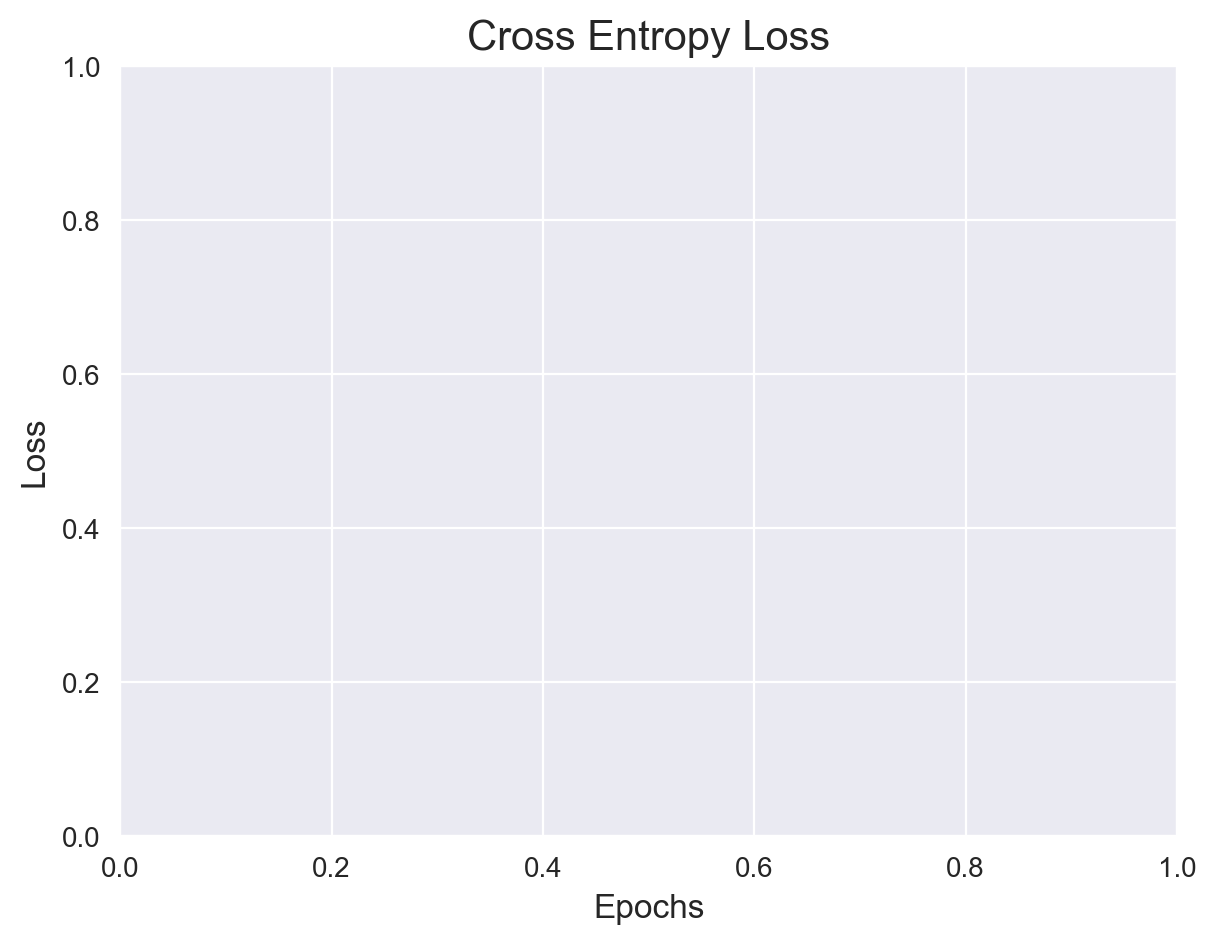

In [81]:
metrics = pd.DataFrame(cnn_model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [82]:
# Evaluate test dataset
loss, acc = cnn_model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = cnn_model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

KeyboardInterrupt: 

In [83]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       0.99      0.96      0.97      1269
           B       0.96      0.98      0.97      1246
           C       0.97      0.99      0.98      1222
           D       0.97      0.98      0.97      1144
           E       0.98      0.97      0.97      1162
           F       1.00      0.97      0.98      1205
           G       0.99      1.00      0.99      1177

    accuracy                           0.98      8425
   macro avg       0.98      0.98      0.98      8425
weighted avg       0.98      0.98      0.98      8425



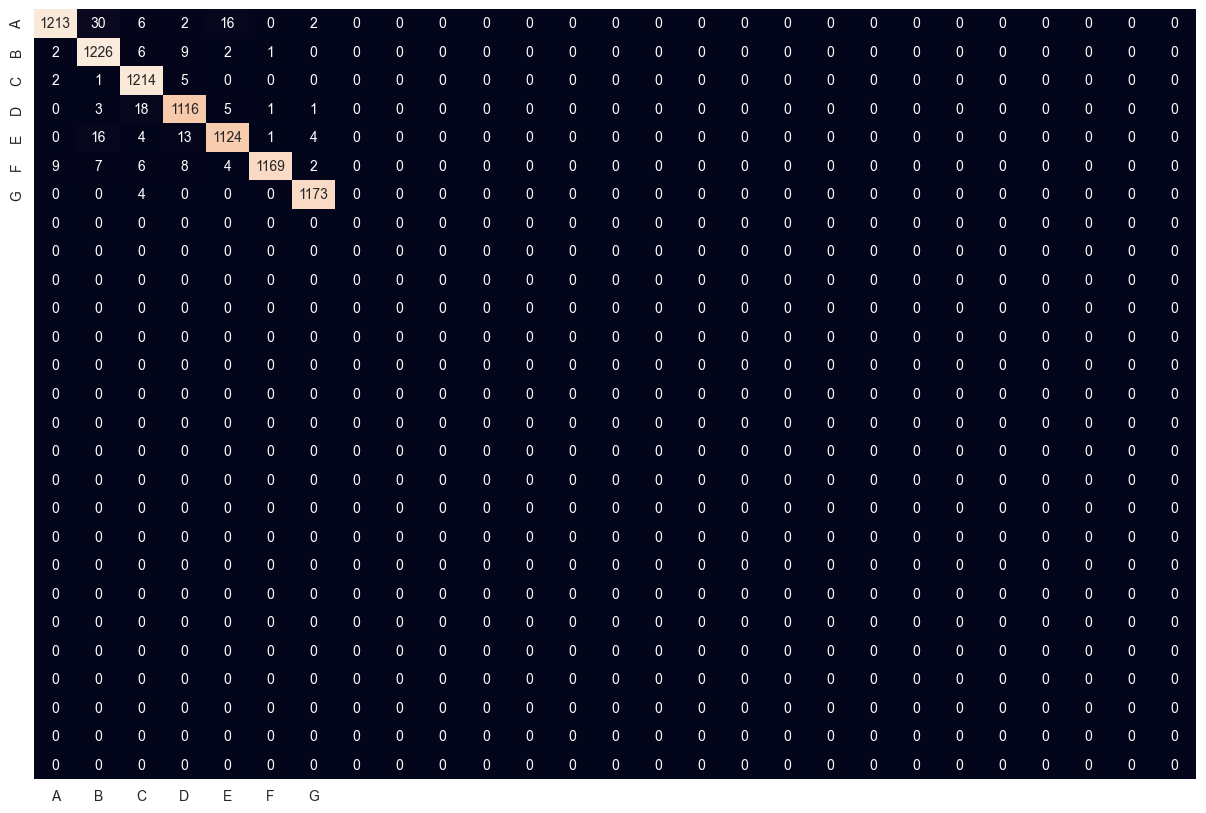

In [84]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

**InceptionV3**

In [85]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,274,107 (100.23 MB)

 Trainable params: 26,239,675 (100.10 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [86]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

inceptionV3Model = Model(inputs=base_model.input, outputs=predictions)

display(inceptionV3Model.summary())
# display(tf.keras.utils.plot_model(inceptionV3Model, to_file='inceptionV3.png', show_shapes=True))

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 63, 63,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 61, 61,    │      9,216 │ activation_97[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 61, 61,    │     18,432 │ activation_98[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 30, 30,    │          0 │ activation_99[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 30, 30,    │      5,120 │ max_pooling2d_7[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_100[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 28, 28,    │    138,240 │ activation_100[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_101[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_101      │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 26,274,107 (100.23 MB)

 Trainable params: 4,471,323 (17.06 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None

In [87]:
# Compile and train the model
inceptionV3Model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
inceptionV3Model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/30


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 7), output.shape=(None, 27)

function ClickConnect(){
  console.log("Working");
  document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect, 60000)


In [88]:
inceptionV3Model.save('inceptionV3_model.h5')
! cp inceptionV3_model.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

'cp' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


KeyError: 'loss'

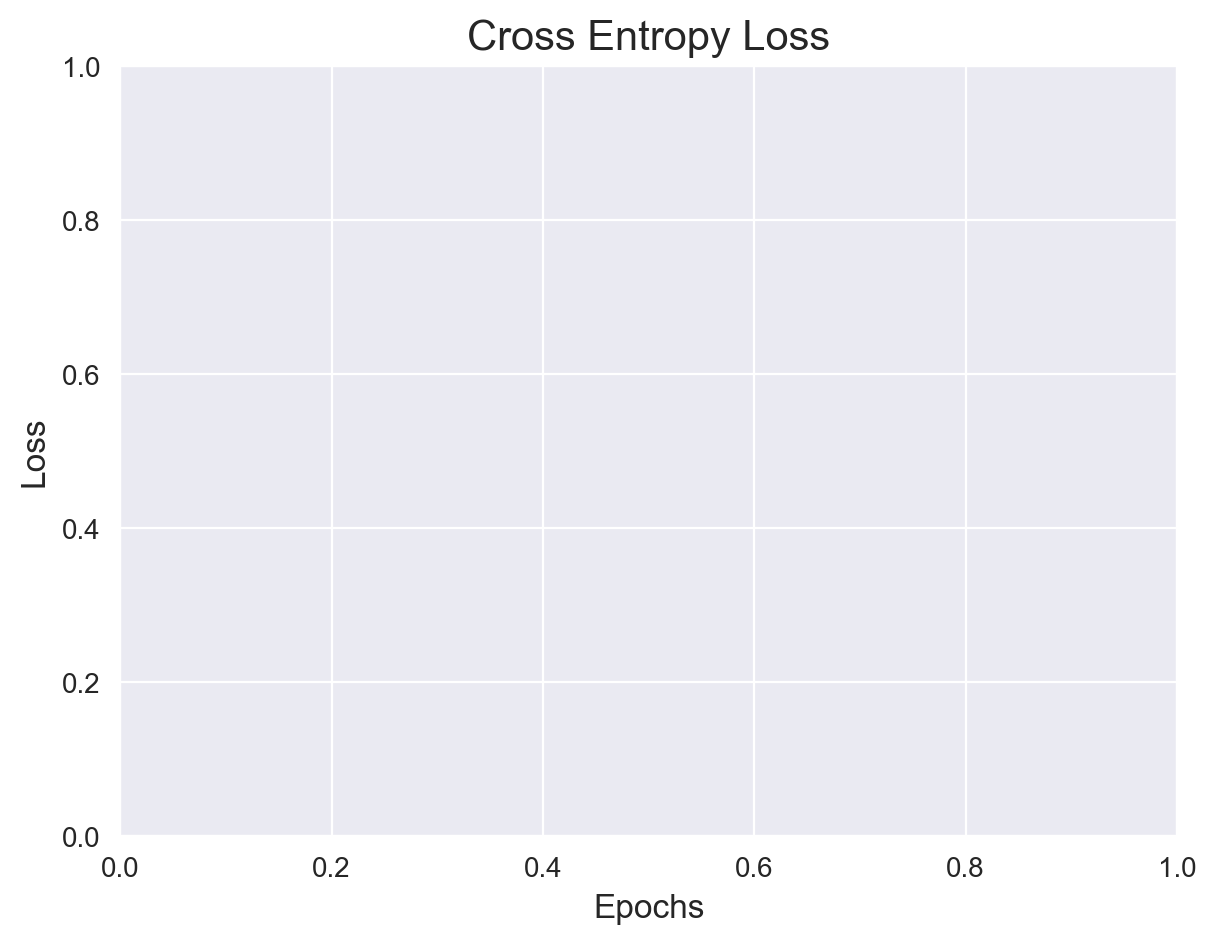

In [89]:
metrics = pd.DataFrame(inceptionV3Model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [90]:
# Evaluate test dataset
loss, acc = inceptionV3Model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = inceptionV3Model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 27)

In [91]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       0.99      0.96      0.97      1269
           B       0.96      0.98      0.97      1246
           C       0.97      0.99      0.98      1222
           D       0.97      0.98      0.97      1144
           E       0.98      0.97      0.97      1162
           F       1.00      0.97      0.98      1205
           G       0.99      1.00      0.99      1177

    accuracy                           0.98      8425
   macro avg       0.98      0.98      0.98      8425
weighted avg       0.98      0.98      0.98      8425



**ResNet**

In [92]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

47448064/94668760 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

KeyboardInterrupt: 

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

resNetModel = Model(inputs=base_model.input, outputs=predictions)

display(resNetModel.summary())
# display(tf.keras.utils.plot_model(inceptionV3Model, to_file='inceptionV3.png', show_shapes=True))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

None

In [ ]:
# Compile and train the model
resNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
resNetModel.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

In [ ]:
resNetModel.save('resnet_model.h5')
! cp resnet_model.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

categories.pkl	resnet_model.h5  vgg16_model6.h5  vgg16_model.h5


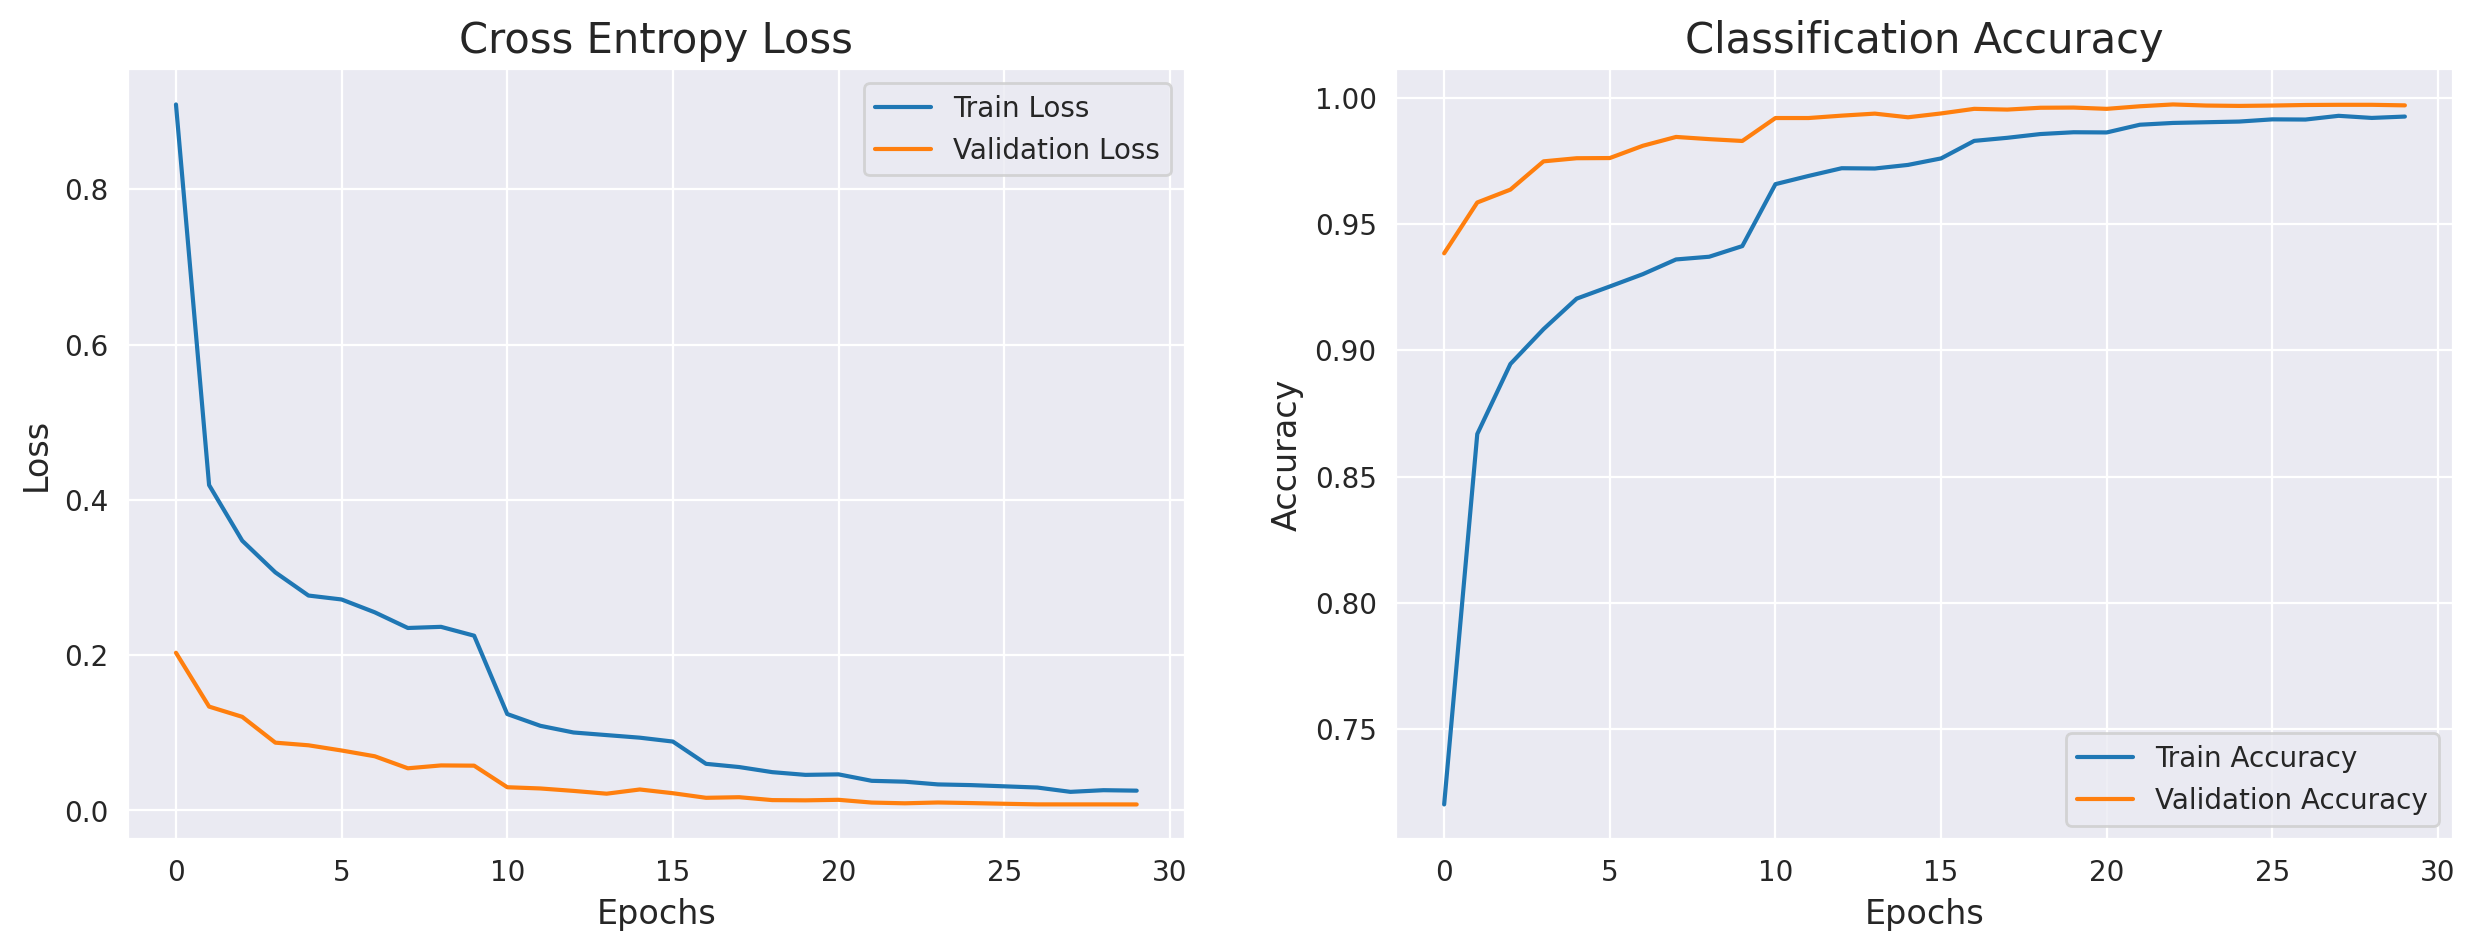

In [ ]:
metrics = pd.DataFrame(resNetModel.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = resNetModel.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = resNetModel.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.70370531082153
The Loss of the model for testing data is: 0.008748874068260193
Correct predicted classes: 12114
Incorrect predicted classes: 36


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       0.99      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      0.99      1.00       450
           L       1.00      1.00      1.00       450
           M       0.99      1.00      1.00       450
           N       1.00      0.99      1.00       450
           O       1.00      1.00      1.00       450
           P       1.00      0.99      1.00       450
           Q       0.99      1.00      1.00       450
           R       0.98    

**DenseNet**

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               8389120   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                       

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

denseNetModel = Model(inputs=base_model.input, outputs=predictions)

display(denseNetModel.summary())
# display(tf.keras.utils.plot_model(inceptionV3Model, to_file='inceptionV3.png', show_shapes=True))

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

None

In [ ]:
# Compile and train the model
denseNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
denseNetModel.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

In [ ]:
denseNetModel.save('densenet_model.h5')
! cp densenet_model.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

categories.pkl	densenet_model.h5  resnet_model.h5  vgg16_model6.h5  vgg16_model.h5


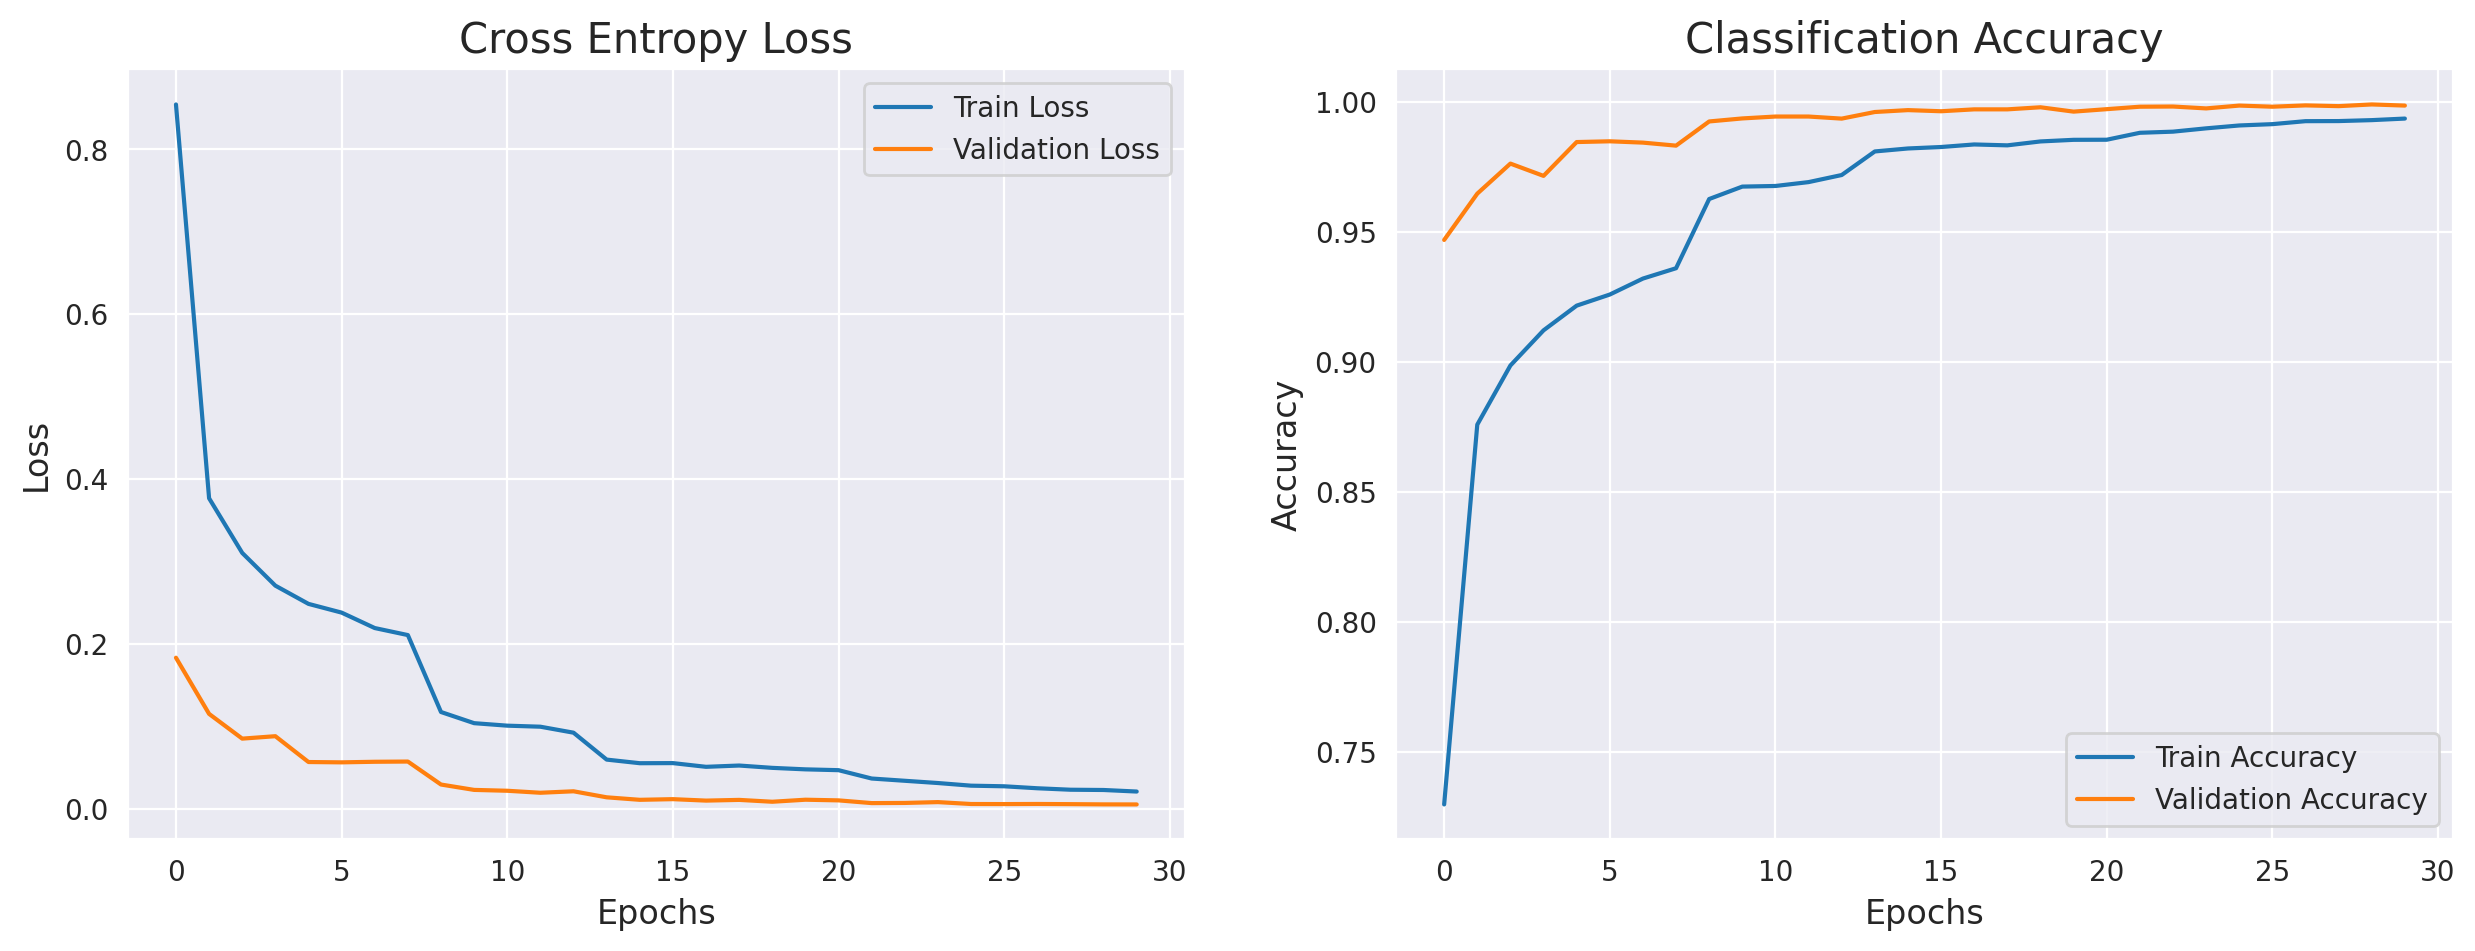

In [ ]:
metrics = pd.DataFrame(denseNetModel.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = denseNetModel.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = denseNetModel.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.80247020721436
The Loss of the model for testing data is: 0.006620797328650951
Correct predicted classes: 12126
Incorrect predicted classes: 24


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      1.00      1.00       450
           O       1.00      0.99      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       0.99    

**Custom CNN**

In [ ]:
custModel = Sequential()

custModel.add(Conv2D(64, (3, 3), padding='same', input_shape=(128,128, 3), activation='relu'))
custModel.add(MaxPool2D(pool_size=(2, 2)))
custModel.add(BatchNormalization())

custModel.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
custModel.add(MaxPool2D(pool_size=(2, 2)))
custModel.add(BatchNormalization())
custModel.add(Dropout(0.2))

custModel.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
custModel.add(MaxPool2D(pool_size=(2, 2)))
custModel.add(BatchNormalization())

custModel.add(Flatten())
custModel.add(Dense(1024, activation='relu'))
custModel.add(Dropout(0.2))
custModel.add(Dense(27, activation='softmax'))

custModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                        

In [ ]:
# Compile and train the model
custModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
custModel.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

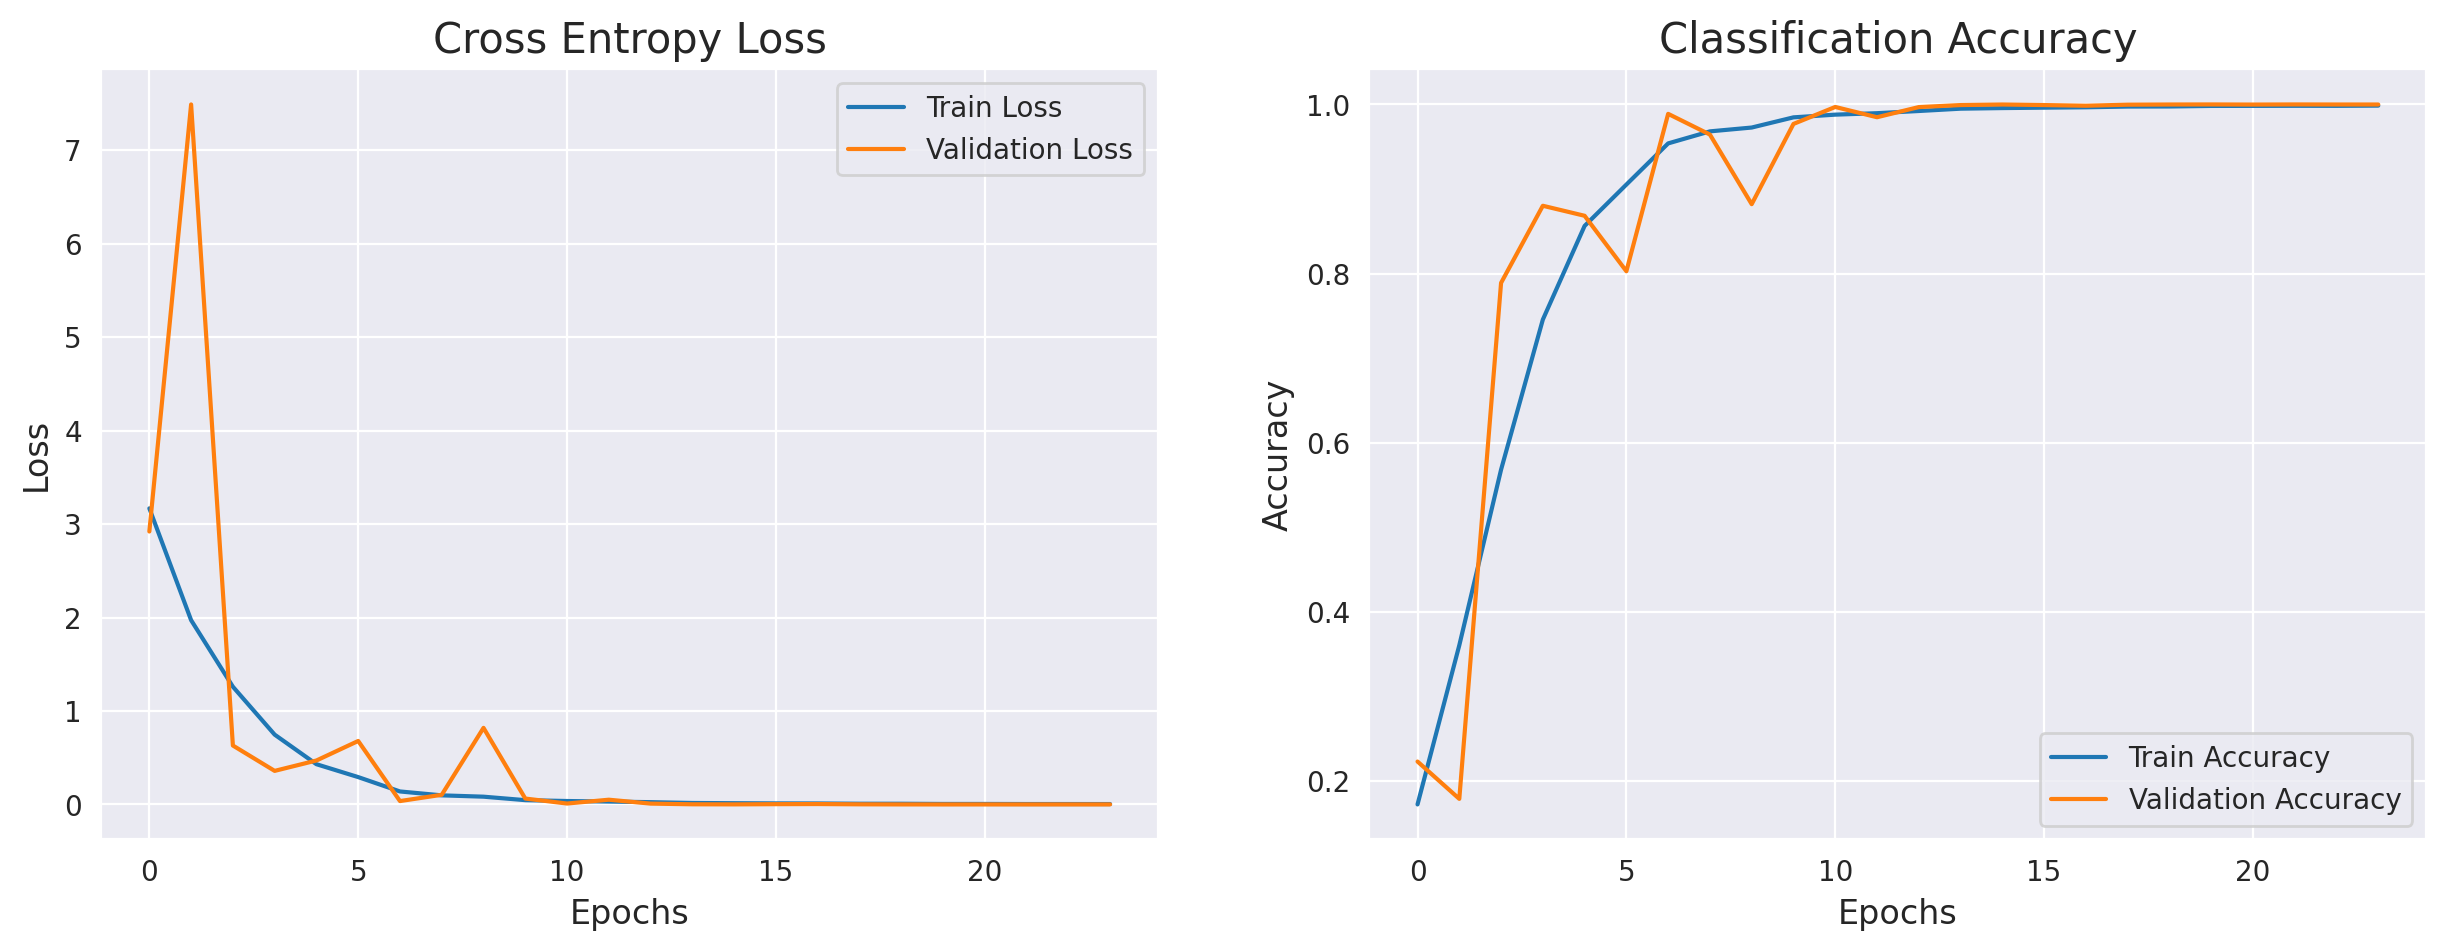

In [ ]:
metrics = pd.DataFrame(custModel.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = custModel.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = custModel.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.97530579566956
The Loss of the model for testing data is: 0.00097813387401402
Correct predicted classes: 12147
Incorrect predicted classes: 3


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      1.00      1.00       450
           O       1.00      1.00      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       1.00    

In [ ]:
custModel.save('custcnn_model_new1.h5')
! cp custcnn_model_new1.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

asl_model  cnn_large_model.h5  custcnn_model_new1.h5  custcnn_model_new.h5


In [ ]:
print("Done :)")

Done :)
